In [1]:
# Codeblock 1
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
# Codeblock 2
def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def rescale_image(image, desired_width=300):
    scale = desired_width/image.shape[1]
    desired_height = int(image.shape[0]*scale)
    image = cv2.resize(image, dsize=(desired_width, desired_height))
    
    return image, desired_height, desired_width

In [3]:
# Codeblock 3
image = load_image('images/hand5.png')
image, height, width = rescale_image(image, desired_width=300)

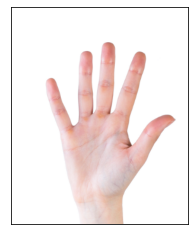

In [4]:
# Codeblock 4
def show_image(image):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

show_image(image)

In [5]:
# Codeblock 5
mp_hands = mp.solutions.hands    # (1)
hands = mp_hands.Hands(static_image_mode=True, 
                       max_num_hands=5, min_detection_confidence=0.3)  # (2)
results = hands.process(image)    # (3)

In [6]:
# Codeblock 6
print(len(results.multi_handedness))
print(len(results.multi_hand_landmarks))

1
1


In [7]:
# Codeblock 7
classification = results.multi_handedness[0]
classification

classification {
  index: 0
  score: 0.9857887029647827
  label: "Left"
}

In [8]:
# Codeblock 8
hand_landmarks = results.multi_hand_landmarks[0]
hand_landmarks

landmark {
  x: 0.48236173391342163
  y: 0.8623615503311157
  z: 1.4232809917302802e-06
}
landmark {
  x: 0.6065046191215515
  y: 0.8018989562988281
  z: -0.08395667374134064
}
landmark {
  x: 0.694269597530365
  y: 0.6882966756820679
  z: -0.12305436283349991
}
landmark {
  x: 0.7808624505996704
  y: 0.5853161811828613
  z: -0.1536012589931488
}
landmark {
  x: 0.8796625137329102
  y: 0.5240564346313477
  z: -0.18402057886123657
}
landmark {
  x: 0.6055797338485718
  y: 0.5387496948242188
  z: -0.08164287358522415
}
landmark {
  x: 0.6711940765380859
  y: 0.4032759368419647
  z: -0.13694128394126892
}
landmark {
  x: 0.7086526155471802
  y: 0.3104059100151062
  z: -0.18004415929317474
}
landmark {
  x: 0.733339250087738
  y: 0.23434284329414368
  z: -0.21198786795139313
}
landmark {
  x: 0.511279284954071
  y: 0.5283918380737305
  z: -0.07926124334335327
}
landmark {
  x: 0.5343390703201294
  y: 0.37915104627609253
  z: -0.13248901069164276
}
landmark {
  x: 0.5446441173553467
  y: 0.

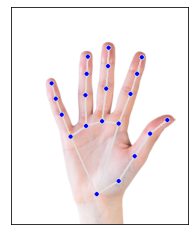

In [9]:
# Codeblock 9
image_with_landmarks = image.copy()   #(1)
 
mp_drawing = mp.solutions.drawing_utils
mp_drawing.draw_landmarks(image_with_landmarks, hand_landmarks, 
                          mp_hands.HAND_CONNECTIONS)  #(2)

show_image(image_with_landmarks)

In [10]:
# Codeblock 10
index_finger_coord = results.multi_hand_landmarks[0].landmark[8]
index_finger_coord

x: 0.733339250087738
y: 0.23434284329414368
z: -0.21198786795139313

In [11]:
# Codeblock 11
index_finger_coord_real = [int(index_finger_coord.x*width), 
                           int(index_finger_coord.y*height)]
index_finger_coord_real

[220, 86]

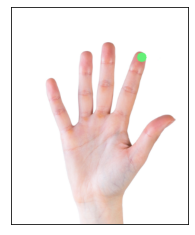

In [12]:
# Codeblock 12
index_finger_landmark = image.copy()
index_finger_landmark = cv2.circle(img=index_finger_landmark, 
                                   center=index_finger_coord_real, 
                                   radius=8, color=(100,240,120), thickness=-1)
show_image(index_finger_landmark)

In [13]:
# Codeblock 13
def find_finger_positions(handedness, landmarks):
    finger_positions = [0, 0, 0, 0, 0]    # pointing indwards: 0, outwards: 1
    fingers = [4, 8, 12, 16, 20]    # Tip finger indices
    for i, finger in enumerate(fingers):
        if finger != 4:      # If not thumb
            if landmarks[finger].y < landmarks[finger-1].y:
                finger_positions[i] = 1
            else:
                finger_positions[i] = 0
        elif finger == 4:    # If thumb
            if handedness == 'Left':
                if landmarks[finger].x > landmarks[3].x:
                    finger_positions[i] = 1
                else:
                    finger_positions[i] = 0
            elif handedness == 'Right':
                if landmarks[finger].x < landmarks[finger+1].x:
                    finger_positions[i] = 1
                else:
                    finger_positions[i] = 0
    
    return finger_positions

In [14]:
# Codeblock 14
find_finger_positions(classification.classification[0].label, 
                      hand_landmarks.landmark)

[1, 1, 1, 1, 1]

In [15]:
# Codeblock 15
def count_fingers(image, desired_width=300, draw_landmarks=True, min_conf=0.5):
    
    # Rescale image
    image, height, width = rescale_image(image, desired_width=desired_width)
    
    # Instantiating hand detector
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=5, 
                           min_detection_confidence=min_conf)
    
    # Detecting hands
    results = hands.process(image)
    
    # Taking detection information
    multi_handedness = results.multi_handedness
    multi_hand_landmarks = results.multi_hand_landmarks
    
    # Counting the fingers
    finger_up = 0
    for classification, hand_landmarks in zip(multi_handedness, multi_hand_landmarks):    
        finger_positions = find_finger_positions(classification.classification[0].label, 
                                                 hand_landmarks.landmark)
        finger_up += sum(finger_positions)
    
    # Write the number of fingers pointing outwards
    cv2.putText(img=image, text=str(finger_up), org=(10,40), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                color=(0,200,0), thickness=2)
    
    # Will run if we set the draw_landmarks to True (optional)
    if draw_landmarks:
        mp_drawing = mp.solutions.drawing_utils
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    # Return the original image alongside the number of fingers pointing upwards
    return image

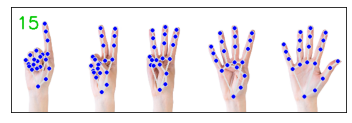

In [16]:
# Codeblock 16
image = load_image('images/all_hands.png')
image = count_fingers(image, desired_width=600, min_conf=0.3)
show_image(image)

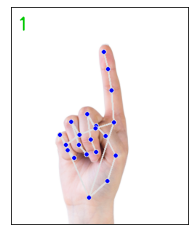

In [17]:
image = load_image('images/hand1.png')
image = count_fingers(image, desired_width=300, min_conf=0.9)
show_image(image)

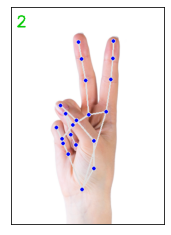

In [18]:
image = load_image('images/hand2.png')
image = count_fingers(image, desired_width=300, min_conf=0.9)
show_image(image)

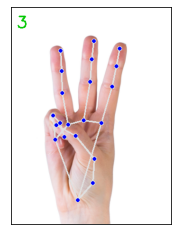

In [19]:
image = load_image('images/hand3.png')
image = count_fingers(image, desired_width=300, min_conf=0.9)
show_image(image)

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

while True:
    _, image, = cap.read()
    image = cv2.flip(image, flipCode=1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    try:
        image = count_fingers(image, desired_width=640)
    except:
        image, height, width = rescale_image(image, desired_width=640)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    cv2.imshow('image', image)